# Pulse sequence optimization
This script performs the pulse sequence optimization to replicate Fig. 2 and Tab. 1 in the paper [Rapid quantitative magnetization transfer imaging: utilizing the hybrid state and the generalized Bloch model](https://doi.org/10.48550/arXiv.2207.08259). Below, we also outline modifications to replicate the Supporting Figs. 2 and 3.

First, we load all required packages:

In [1]:
using Pkg
Pkg.activate(".")
using MRIgeneralizedBloch
using LinearAlgebra
BLAS.set_num_threads(1) # single threaded is faster in this case
using Optim             # provides the optimization algorithm
using Plots

  Activating project at `~/Documents/scripts/2021_HSFP_MT_Paper/HSFP_qMT_SupportingNotebooks`


We define the point in the parameter space at which we optimize:

In [2]:
m0s = 0.1
R1f = 0.625 # 1/s
R2f = 15    # 1/s
Rx  = 30    # 1/s
R1s = R1f   # 1/s
T2s = 10e-6 # s
R2slT = precompute_R2sl()

ω0 = 0      # rad/s
B1 = 1;      # in units of B1_nominal

The following list of gradients defines all parameters that are considered *unknown* in the optimization and the weights scale the CRB values in the optimization. Here we optimize for the CRBs of $m_0^s$, the apparent $R_1^a$, and $R_2^f$, normalized by respective squared value and while considering $m_0^s$, $R_1^a$, $R_2^f$, $R_x$, $T_2^s$, $ω_0$, and $B_1$ as unknowns that will ultimately be fitted.

In [3]:

grad_list = [grad_m0s(), grad_R1a(), grad_R2f(), grad_Rx(), grad_T2s(), grad_ω0(), grad_B1()]
weights = transpose([0, 1/m0s^2, 1/R1f^2, 1/R2f^2, 0, 0, 0, 0]);

Set up some hard-coded sequence parameters:

In [4]:
Npulses = 1142
TR = 3.5e-3; # s

Initialize RF-pattern

In [5]:
α = 0.7 * abs.(sin.((1:Npulses) * 2π/Npulses))
TRF = 499.5e-6 .* one.(α);

The following cell defines the first RF pulse as an inversion pulse (with crusher gradients). This reproduces Fig. 2 in the main article and is also the correct setting for replicating the Supporting Fig. 2 (that uses a fixed $T_{RF}$). To replicate the Supporting Fig. 3 that forgoes the inversion pulse, replace the entire cell with `isInversionPulse = falses(length(α))`.

In [6]:
α[1] = π
TRF[1] = 500e-6
isInversionPulse = [true; falses(length(α)-1)];

Calculate the Rabi frequency of each RF pulse and plot the initialization.

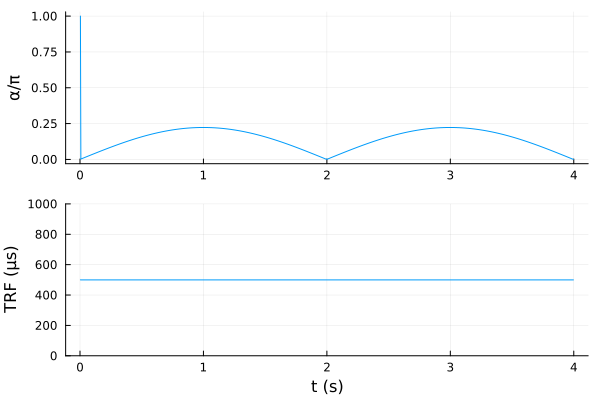

In [7]:
ω1 = α ./ TRF

p1 = plot(TR*(1:Npulses), α ./ π, ylabel="α/π")
p2 = plot(TR*(1:Npulses), 1e6TRF, ylim=(0, 1e3), xlabel="t (s)", ylabel="TRF (μs)")
plot(p1, p2, layout=(2, 1), legend=:none)

Define bounds for the optimization. The Rabi frequency is limited to our system's (Prisma, Siemens, Germany) maximum transmit field minus some safety margin to ensure that the sequence robustly runs for different patients. The pulse duration $T_{RF}$ has an heuristically chosen lower bound and and upper bound that ensure proper timing of the pulse sequence given $T_R = 3.5$ ms, 1mm nominal resolution, and the gradient specifications of our system. 

These settings reproduce Fig. 2 in the main article or Supporting Fig. 3 (see above). To reproduce Supporting Fig. 2, which uses a constant $T_{RF}$, replace the third line with `TRF_min = 499e-6 # s`. Note that an internal rescaling returns an error if `TRF_min == TRF_max`, hence we need to allow a small margin. 

In [8]:
ω1_min  = 0       # rad/s
ω1_max  = 2e3π    # rad/s
TRF_min = 100e-6  # s
TRF_max = 500e-6; # s

Define optimization problem:

In [9]:
x0 = MRIgeneralizedBloch.bound_ω1_TRF!(ω1, TRF; ω1_min = ω1_min, ω1_max = ω1_max, TRF_min = TRF_min, TRF_max = TRF_max)
G = similar(x0)

function fg!(F, G, x)
    ω1, TRF = MRIgeneralizedBloch.get_bounded_ω1_TRF(x; ω1_min = ω1_min, ω1_max = ω1_max, TRF_min = TRF_min, TRF_max = TRF_max)

    (F, grad_ω1, grad_TRF) = MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, weights, isInversionPulse=isInversionPulse)
    F = abs(F)

    F += MRIgeneralizedBloch.second_order_α!(grad_ω1, grad_TRF, ω1, TRF; λ=1e4)
    F += MRIgeneralizedBloch.RF_power!(grad_ω1, grad_TRF, ω1, TRF, λ=1e-3, Pmax=3e5, TR=TR)
    F += MRIgeneralizedBloch.TRF_TV!(grad_TRF, ω1, TRF; λ=1e3)

    MRIgeneralizedBloch.apply_bounds_to_grad!(G, x, grad_ω1, grad_TRF; ω1_min = ω1_min, ω1_max = ω1_max, TRF_min = TRF_min, TRF_max = TRF_max)
    return F
end;

Run the optimization:

In [10]:
result = optimize(Optim.only_fg!(fg!), # cost function
    x0,                                # initialization
    BFGS(),                            # algorithm
    Optim.Options(
        iterations=1_000_000,          # larger number as we use a time limit
        time_limit=(2*60),          # in seconds
        show_trace = false
        )
    )

 * Status: failure (exceeded time limit of 120.0)

 * Candidate solution
    Final objective value:     3.962390e+02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = 1.18e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.98e-03 ≰ 0.0e+00
    |g(x)|                 = 2.10e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   121  (vs limit 120)
    Iterations:    67
    f(x) calls:    246
    ∇f(x) calls:   246


Unpack and plot the optimization result:

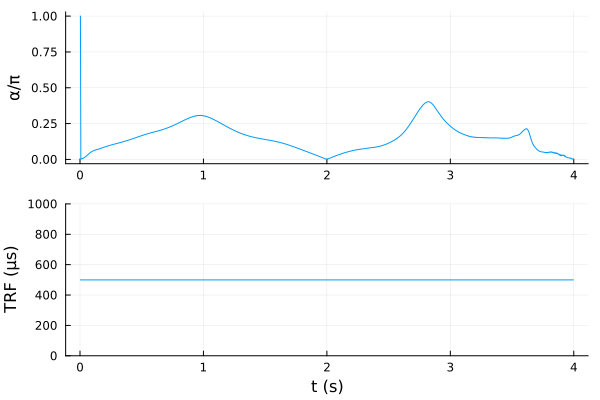

In [11]:
ω1, TRF = MRIgeneralizedBloch.get_bounded_ω1_TRF(result.minimizer; ω1_min = ω1_min, ω1_max = ω1_max, TRF_min = TRF_min, TRF_max = TRF_max)
α = ω1 .* TRF

p1 = plot(TR*(1:Npulses), α ./ π, ylabel="α/π")
p2 = plot(TR*(1:Npulses), 1e6TRF, ylim=(0, 1e3), xlabel="t (s)", ylabel="TRF (μs)")
plot(p1, p2, layout=(2, 1), legend=:none)

Simulate and plot the spin dynamics:

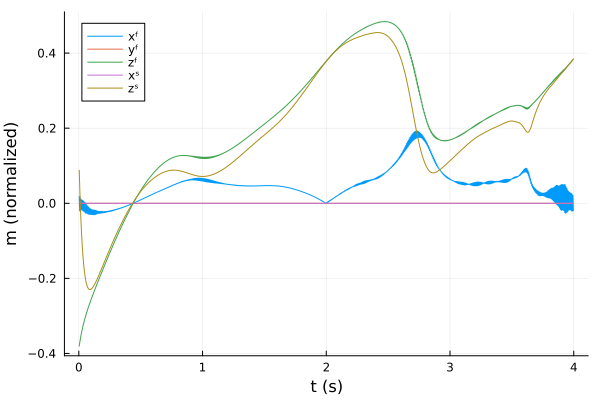

In [12]:
m = calculatesignal_linearapprox(α, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT; output=:realmagnetization)
m = vec(m)

xf = [m[i][1] for i=1:length(m)]
yf = [m[i][2] for i=1:length(m)]
zf = [m[i][3] for i=1:length(m)]
xs = [m[i][4] for i=1:length(m)]
zs = [m[i][5] for i=1:length(m)]

plot(xlabel="t (s)", ylabel="m (normalized)")
plot!(TR*(1:Npulses), xf ./(1-m0s), label="xᶠ")
plot!(TR*(1:Npulses), yf ./(1-m0s), label="yᶠ")
plot!(TR*(1:Npulses), zf ./(1-m0s), label="zᶠ")
plot!(TR*(1:Npulses), xs ./   m0s , label="xˢ")
plot!(TR*(1:Npulses), zs ./   m0s , label="zˢ")

Plot the spin dynamics of the free spin pool on the Bloch sphere:

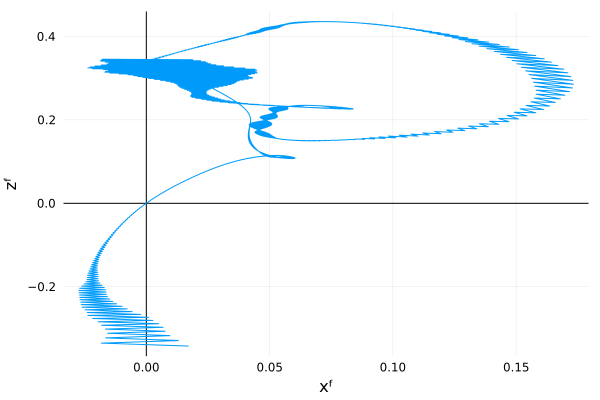

In [13]:
plot(xf, zf, xlabel="xᶠ", ylabel="zᶠ", framestyle = :zerolines, legend=:none)

## Calculate the normalized Cramer-Rao-bound values the optimized RF-pattern

Normalized CRB of $m_0^s$ in seconds:

In [14]:
w_eval = transpose([0, 1/m0s^2, 0, 0, 0, 0, 0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

813.899322219829

Normalized CRB of $R_1^a$ in seconds:

In [15]:
w_eval = transpose([0, 0, 1/R1f^2, 0, 0, 0, 0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

192.55737558799447

Normalized CRB of $R_2^f$ in seconds:

In [16]:
w_eval = transpose([0, 0, 0, 1/R2f^2, 0, 0, 0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

209.80066936336272

Normalized CRB of $M_0$ in seconds:

In [17]:
w_eval = transpose([1.0, 0, 0, 0, 0, 0, 0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

709.3157157339822

Normalized CRB of $R_x$ in seconds:

In [18]:
w_eval = transpose([0, 0, 0, 0, 1/Rx^2, 0, 0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

73684.12491284998

Normalized CRB of $T_2^s$ in seconds:

In [19]:
w_eval = transpose([0, 0, 0, 0, 0, 1/T2s^2, 0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

21051.447722184308

Normalized CRB of $ω_0$:

In [20]:
w_eval = transpose([0, 0, 0, 0, 0, 0, 1.0, 0])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

64898.39729707108

Normalized CRB of $B_1$ in seconds:

In [21]:
w_eval = transpose([0, 0, 0, 0, 0, 0, 0, 1/B1^2])
w_eval .*= TR * Npulses
MRIgeneralizedBloch.CRB_gradient_OCT(ω1, TRF, TR, ω0, B1, m0s, R1f, R2f, Rx, R1s, T2s, R2slT, grad_list, w_eval, isInversionPulse=isInversionPulse)[1]

749.7333753252124